# Copula Approach : CMS Spread Options
--------------------------------------
> **Idriss Afra**

This project aims to price CMS Spread Options using the Copula approach.

## Model Description

CMS spread derivatives are popular financial instruments whose payoff is function of spread between two swap rates with different tenors. In fact, they are traded by parties seeking to take advantage from future changes in the yield curve slopes.

Let us assume a CMS spread caplet (Similar reasoning for Floorlets) paying $MAX\left(S^1_{T_f} - S^2_{T_f} -K; 0\right)$  at $T_p$, where :

* $T_f$ is the expiry (fixing) date
* $S^1$ is the forward swap rate of tenor $T_1$
* $S^2$ is the forward swap rate of tenor $T_2$
* $K$ is the strike spread rate

The price of this caplet under the $T_p$-forward measure $Q^{T_p}$ is :    

\begin{equation}
\begin{split}
PV & = B(0, Tp) \times E^{Q^{T_p}} \left( MAX\left(S^1_{T_f} - S^2_{T_f} -K; 0\right) \right) \\
& = B(0, Tp) \times E^{Q^{T_p}} \left( MAX\left(CMS^1_{T_f} - CMS^2_{T_f} -K; 0\right) \right)  \\
\end{split}
\end{equation}

Where :    

* $B(0, Tp)$ is the zero-coupon price up to $T_p$ (discount factor)
* $CMS^1_{t} = E^{Q^{T_p}}_t(S^1_{T_f})$ is the forward Constant Maturity Swap (CMS) of tenor $T_1$ and payment date $T_p$
* $CMS^2_{t} = E^{Q^{T_p}}_t(S^2_{T_f})$ is the forward Constant Maturity Swap
 (CMS) of tenor $T_2$ and payment date $T_p$

Hence the name of "CMS Spread Option" given to these products...

The price formula can then be re-written as :    

\begin{equation}
\begin{split}
PV & = B(0, Tp) × ∫_{-∞}^{+∞}∫_{-∞}^{+∞} MAX\left(s_1 - s_2 - K; 0\right) × f^{Q^{Tp}}_{S^1_{T_f}, S^2_{T_f}}(s_1, s_2) ds_1 ds_2 \\
& = B(0, Tp) × ∫_{-∞}^{+∞}∫_{-∞}^{+∞} MAX(s_1 - s_2 - K; 0) × c_{S^1_{T_f}, S^2_{T_f}}\left(F^{Q^{Tp}}_{S^1_{T_f}}(s_1), F^{Q^{Tp}}_{S^2_{T_f}}(s_2)\right) × f^{Q^{Tp}}_{S^1_{T_f}}(s_1), f^{Q^{Tp}}_{S^2_{T_f}}(s_2) ds_1 ds_2
\end{split}
\end{equation}

Where :    

* $f^{Q^{Tp}}_{S^1_{T_f}, S^2_{T_f}}$ is the joint PDF of $(S^1_{T_f}, S^2_{T_f})$ under $Q^{Tp}$
* $F^{Q^{Tp}}_{S^i_{T_f}}$ and $f^{Q^{Tp}}_{S^i_{T_f}}$ are respectively the CDF and PDF of $S^i_{T_f}$ under $Q^{Tp}$
* $c_{S^1_{T_f}, S^2_{T_f}}$ is the copula density function of $(S^1_{T_f}, S^2_{T_f})$

In this project, we will use the bivariate Gaussian copula density since the other copulas need extra parameters which are difficult or impossible to calibrate.

#### PDF under the Level Measure

Under the level measure $Q^{LVL}$, the PDF of $S_{T_f}$ can be stripped from OTM swaptions forward prices via the Breeden & Litzenberger formula :

\begin{equation}
\begin{split}
f^{Q^{LVL}}_{S_{T_f}}(K) & = \frac{d^2PV_{Swaption}(T_f, K)}{dK^2} \\
\end{split}
\end{equation}

<br>Where : $PV_{Swaption}(T_f, K) = E^{Q^{LVL}}\left(MAX\left(S_{T_f} - K; 0\right)\right)$, if : $K \ge S_0$ \\

Otherwise  : $PV_{Swaption}(T_f, K) = E^{Q^{LVL}}\left(MAX\left(K - S_{T_f}; 0\right)\right)$  

In this project, we will consider the normal (Bachelier) model as market model for swaptions and we will use the finite difference method to strip the PDF. We note that shifting the strike rate should have an impact on the used normal volatility.

#### PDF & CDF under the Forward Measure

Thanks to the Radon-Nikodym theorem, we can link the PDFs of $S_{T_f}$ under the level $Q^{LVL}$ and forward $Q^{T_p}$ measures  :

\begin{equation}
\begin{split}
f^{Q^{T_p}}_{S_{T_f}}(s) & = \frac{LVL_0}{B(0, T_p)} × g(s) × f^{Q^{LVL}}_{S_{T_f}}(s) \\
\end{split}
\end{equation}

Where :
* $g\left(S(T_f, T_0, T_1)\right) := \frac{B(T_f, T_p)}{LVL(T_f,T_0, T_1)}$ is the TSR function

* $LVL_0 = ∑_{T^p_i ∈ SwapPayDates} DCF_i × B(0, T^p_{i})$ ($DCF$ : Day Count Fraction)

The CDF of $S_{T_f}$ under the forward measure is then computed as follows :   

\begin{equation}
\begin{split}
F^{Q^{T_p}}_{S_{T_f}}(s) & = \frac{LVL_0}{B(0, T_p)} × ∫_{-∞}^s g(u) × f^{Q^{LVL}}_{S_{T_f}}(u)du \\
\end{split}
\end{equation}

In this project, we will use the Mean Reversion Linear TSR model to define the function $g$.

## TSR Model : Mean Reversion Linear

We first implement the TSR model class. More details are provided in [CMS Convexity Adjustment](https://github.com/Idriss-Afra/CMS-Convexity-Adjustment/blob/main/CMS%20Convexity%20Adjustment.ipynb).

In [1]:
import numpy as np

class tsr_model :
    """
    TSR model : Mean Reversion Linear flavor
    """
    def __init__(self, df, mean_reversion=0.015) :
        """
        Init method : df is the discount curve function and the HW-1F mean reversion is defaulted to 1.5%
        """
        self.df = df
        self.mean_reversion = mean_reversion

    def beta(self, t, T) :
        """
        HW-1F Beta function
        """
        return (1 - np.exp(-self.mean_reversion * (T - t))) / self.mean_reversion

    def tsr_coeffs(self, expiry, tenor, pay_date) :
        """
        TSR coefficients formulas
        """
        # Dates
        start_time = expiry + 2./365.
        # Swap fixed leg payment dates : Annually
        pay_times = np.arange(start_time + 1, expiry + tenor + 1)
        year_fractions = np.ones(len(pay_times))

        # Intermidiate Variables
        df_start_time = self.df(start_time)
        df_pay_times = self.df(pay_times)
        level = np.sum(df_pay_times * year_fractions)
        swap_fwd = (df_start_time - df_pay_times[-1]) / level
        gamma = np.sum(df_pay_times * year_fractions * self.beta(expiry, pay_times)) / level

        # Results
        num = self.df(pay_date) * (gamma - self.beta(expiry, pay_date))
        den = df_pay_times[-1] * self.beta(expiry, pay_times[-1]) + level * swap_fwd * gamma
        a = num / den
        b = self.df(pay_date) / level - a * swap_fwd

        return {"a" : a, "b" : b}

## IR Swaption :  The Normal Model

Then, we implement the Swaption instrument class :

In [2]:
from scipy.stats import norm
import math

class swaption :
    """
    Vanilla instrument "Swaption"
    """
    def __init__(self, payer_receiver, expiry, tenor, strike, notional = 1.):
        """
        Init method
        """
        self.payer_receiver = payer_receiver
        self.expiry = expiry
        self.strike = strike
        self.notional = notional
        self.start_time = expiry + 2./365.
        # Fixed leg payment dates : Annually
        self.pay_times = np.arange(self.start_time + 1, expiry + tenor + 1)
        self.year_fractions = np.ones(len(self.pay_times))

    def set_market_data(self, df, normal_vol):
        """
        Store DFs values to save computation time
        """
        self.df_exp_time = df(self.expiry)
        self.df_start_time = df(self.start_time)
        self.df_pay_times = df(self.pay_times)
        self.normal_vol = normal_vol

    def level(self) :
      """
      The level function : Sum of DCF(T(i)) * B(0, T(i)) where T(i) are the fixed leg pay dates
      """
      return np.sum(self.df_pay_times * self.year_fractions)

    def forward(self):
        """
        The forward level of the swap rate
        """
        return (self.df_start_time - self.df_pay_times[-1]) / self.level()

    def pv_underlying(self):
        """
        PV of the underlying swap
        """
        phi = 1. if (self.payer_receiver.upper()=='PAYER') else -1.
        return phi * self.notional * self.level() * (self.forward() - self.strike)

    def market_price(self):
        """
        Swaption price under the Normal model
        """
        phi = 1 if (self.payer_receiver.upper()=='PAYER') else -1
        lvl = self.level()
        fwd = self.forward()
        if (self.expiry==0 or self.normal_vol==0) : return max(phi * (fwd - self.strike), 0)
        sqrt_V2T = self.normal_vol * math.sqrt(self.expiry)
        d = (fwd - self.strike) / sqrt_V2T
        return self.notional * lvl * sqrt_V2T * (phi * d * norm.cdf(phi * d) + norm.pdf(d))

    def market_fwd_price(self):
        """
        Swaption forward price under the Normal model
        """
        phi = 1 if (self.payer_receiver.upper()=='PAYER') else -1
        lvl = self.level()
        fwd = self.forward()
        if (self.expiry==0 or self.normal_vol==0) : return max(phi * (fwd - self.strike), 0)
        sqrt_V2T = self.normal_vol * math.sqrt(self.expiry)
        d = (fwd - self.strike) / sqrt_V2T
        return self.notional * sqrt_V2T * (phi * d * norm.cdf(phi * d) + norm.pdf(d))

## The Copula Approach For CMS Spread Options



#### The Bivariate Gaussian Copula Density

As stated in the first section, we use the following bivariate Gaussian copula density :

In [3]:
def gaussian_copula(u1, u2, rho):
    """
    The bivariate Gaussian copula density
    "rho" is the correlation level
    """
    if u1==0 or u2==0 : return 0

    exp_num = 2 * rho * norm.ppf(u1) * norm.ppf(u2) - rho**2 * (norm.ppf(u1)**2 + norm.ppf(u2)**2)
    exp_den = 2 * (1 - rho**2)
    num = math.exp(exp_num / exp_den)
    den = math.sqrt(1 - rho**2)
    return num / den


#### The Simpson's Rule

The copula pricing method is based on heavy integrations. Therefore, we will use the Simpson's rule as an approximation model to reduce the computations time :

In [4]:
def simpson_integral(givenFunction, h, lx, ux):
    """
    Simpson's rule : An approximation method to single integration
    "h" is the step size, "lx" is the lower bound, and "ux" is the upper bound
    """
    # Number of steps
    nx = round((ux - lx) / h + 1)

    result = 0
    for i in range(0, nx):
        if i == 0 or i == nx - 1:
            result += givenFunction(lx + i * h)
        elif i % 2 == 0:
            result += 2 * givenFunction(lx + i * h)
        else:
            result += 4 * givenFunction(lx + i * h)

    result *= (h / 3)

    return result

def simpson_double_integral(givenFunction, h, k, lx, ux, ly, uy):
    """
    Simpson's rule : An approximation method to double integration
    "h" and "k" are the step sizes of (x, y), "lx" and "ly" are the lower bounds, and "ux" and "uy" are the upper bounds
    """
    # Number of steps
    nx = round((ux - lx) / h + 1)
    ny = round((uy - ly) / k + 1)

    # 1 - Compute integrals of y via the Simpson's rule for different values of x : lx + i * h
    ax = [0] * nx
    for i in range(0, nx):
        for j in range(0, ny):
            if j == 0 or j == ny - 1:
                ax[i] += givenFunction(lx + i * h, ly + j * k)
            elif j % 2 == 0:
                ax[i] += 2 * givenFunction(lx + i * h, ly + j * k)
            else:
                ax[i] += 4 * givenFunction(lx + i * h, ly + j * k)
        ax[i] *= (k / 3)

    # 2 - Compute the integral of x by applying the Simpson's rule on the ax values
    result = 0
    for i in range(0, nx):
        if i == 0 or i == nx - 1:
            result += ax[i]
        elif i % 2 == 0:
            result += 2 * ax[i]
        else:
            result += 4 * ax[i]
    result *= (h / 3)

    return result

#### The Copula Pricing Method

In [5]:
from scipy.integrate import quad, dblquad

class copula_method:
    """
    Copula Method : Copula Approach for pricing CMS Spread Options
    """
    def __init__(self, tsr_model):
        """
        Init method
        """
        self.tsr_model = tsr_model
        self.df = tsr_model.df

    def set_data(self, expiry, cms_tenor_1, cms_tenor_2, pay_date, vol_skew_1, vol_skew_2, correl):
        """
        Set data : Dates, Vol Skews, and Intermidiate Parameters
        """
        # Set dates
        self.expiry = expiry
        self.cms_tenor_1 = cms_tenor_1
        self.cms_tenor_2 = cms_tenor_2
        self.pay_date = pay_date
        # Set vol skews
        self.vol_skew_1 = vol_skew_1
        self.vol_skew_2 = vol_skew_2
        self.correl = correl
        # Set intermediate parameters
        self.set_params(expiry, cms_tenor_1, cms_tenor_2, pay_date)

    def set_params(self, expiry, cms_tenor_1, cms_tenor_2, pay_date) :
        """
        Set data : Dates, Vol Skews, and Intermidiate Parameters
        """
        # B(0, Tp) computation
        self.df_pay_date = self.df(pay_date)
        # Start Date = Expiry + 2BD
        self.start_time = self.expiry + 2./365.
        # Level values
        pay_times = np.arange(self.start_time + 1, expiry + cms_tenor_1 + 1)
        year_fractions = np.ones(len(pay_times))
        self.level_1 = np.sum(self.df(pay_times) * year_fractions)
        pay_times = np.arange(self.start_time + 1, self.expiry + self.cms_tenor_2 + 1)
        year_fractions = np.ones(len(pay_times))
        self.level_2 = np.sum(self.df(pay_times) * year_fractions)
        # TSR coeffs
        self.tsr_coeffs_1 = self.tsr_model.tsr_coeffs(expiry, cms_tenor_1, pay_date)
        self.tsr_coeffs_2 = self.tsr_model.tsr_coeffs(expiry, cms_tenor_2, pay_date)

    def pdf_lvl_measure(self, k, cms_tenor, vol_skew):
        """
        PDF under the level measure : Application of the FD method on the Breeden & Litzenberger formula
        """
        swopt = swaption("Payer", self.expiry, cms_tenor, k)
        swopt.set_market_data(self.df, vol_skew(k))
        # Flavor correction
        if k < swopt.forward() :
            swopt.payer_receiver = "Receiver"
        # Central price
        price_k = swopt.market_fwd_price()
        # 2nd order FD : Central shift of 1 Bps
        eps = 0.0001
        swopt.strike = k + eps
        swopt.set_market_data(self.df, vol_skew(k + eps))
        price_k_plus = swopt.market_fwd_price()
        swopt.strike = k - eps
        swopt.set_market_data(self.df, vol_skew(k - eps))
        price_k_minus = swopt.market_fwd_price()
        return (price_k_plus + price_k_minus - 2 * price_k) / eps**2

    def pdf_fwd_measure(self, k, cms_tenor, lvl, vol_skew, tsr_coeffs):
        """
        PDF under the forward measure : Link through the Radon-Nikodym method
        """
        self.df_pay_date = self.df(self.pay_date)
        return (lvl /self.df_pay_date) * (tsr_coeffs["a"] * k + tsr_coeffs["b"]) * self.pdf_lvl_measure(k, cms_tenor, vol_skew)

    def cdf_fwd_measure(self, k, cms_tenor, lvl, vol_skew, tsr_coeffs):
        """
        CDF under the forward measure : Integration of the PDF under the forward measure
        Simpson's rule & proper bounds are considered for the integration in order to reduce the computations time
        """
        self.df_pay_date = self.df(self.pay_date)
        return simpson_integral(lambda s : self.pdf_fwd_measure(s, cms_tenor, lvl, vol_skew, tsr_coeffs), 0.005, -0.04, k) # Step of 50 Bps and lower bound of -4%

    def price(self, flavor, strike):
        """
        CMS Spread Option Price
        Simpson's rule & proper bounds are considered for the integration in order to reduce the computations time
        """
        # Check the flavor type
        if flavor.upper() == "CAPLET" :
            phi = 1.
        elif flavor.upper() == "FLOORLET" :
            phi = -1.
        else :
            print("Undefined flavor type. Possible values : Caplet or Floorlet.")
            return None 

        f = lambda s1, s2 : max(phi * (s1 - s2 - strike), 0) * self.pdf_fwd_measure(s1, self.cms_tenor_1, self.level_1, self.vol_skew_1, self.tsr_coeffs_1) * self.pdf_fwd_measure(s2,
                            self.cms_tenor_2, self.level_2, self.vol_skew_2, self.tsr_coeffs_2) * gaussian_copula(self.cdf_fwd_measure(s1, self.cms_tenor_1, self.level_1, self.vol_skew_1,
                            self.tsr_coeffs_1), self.cdf_fwd_measure(s2, self.cms_tenor_2, self.level_2, self.vol_skew_2, self.tsr_coeffs_2), self.correl)

        return self.df_pay_date * simpson_double_integral(f, 0.005, 0.005, -0.04, 0.1, -0.04, 0.1) # Steps of 50 Bps, lower bounds of -4%, and upper bounds of 10%

## Zero-Coupon Rate Curve

We define a Zero-Coupon curve class to construct discount factor curves :

In [6]:
from scipy.interpolate import interp1d

class zc_curve :
    """
    Zero-Coupon Rates curve
    """
    def __init__(self, maturities, zc_rates):
        """
        Init method : Takes the IR market tenors and the bootstrapped ZC rates
        """
        self.maturities = maturities
        self.zc_rates = zc_rates
        # Cubic Interpolation & Extrapolation
        self.zc_rates_interp = interp1d(maturities, zc_rates, kind='cubic', fill_value="extrapolate")

    def df(self, T):
        """
        Zero-Coupon Discount Factors
        """
        return np.exp(-self.zc_rates_interp(T)*T)

## Volatility Skew

We define a Volatility Skew class to construct normal vol skews through interpolation / extrapolation methods :

In [7]:
class vol_skew :
    """
    Volatility Skew
    """
    def __init__(self, strikes, vol_data) :
        """
        Init method : Takes the strikes and vol points
        """
        self.strikes = strikes
        self.vol_data = vol_data

    def vol_skew(self, strike) :
        """
        Construct vol Skews through cubic interpolation and linear extrapolation
        Output : normal_vol(expiry, strike)
        """
        if strike < self.strikes[0] or strike > self.strikes[-1] :
            return interp1d(self.strikes, self.vol_data, kind='linear', fill_value="extrapolate")(strike)
        return interp1d(self.strikes, self.vol_data, kind='cubic', fill_value="extrapolate")(strike)

## Application

Let us compute prices of 10Y-2Y CMS spread options with an expiry of 5Y, asof 1st Febrary 2024 :

In [8]:
# IR yield curve asof 1st Febrary 2024 (EURIBOR 6M)
maturities = np.array([0.5, 1, 2, 5, 6, 8, 10, 15, 20, 30])
zc_rates = np.array([3.84, 3.41, 2.84, 2.48, 2.47, 2.49, 2.52, 2.6, 2.53, 2.28]) / 100
yc = zc_curve(maturities, zc_rates)

# Expiry & Pay Dates
expiry = 5.
pay_date = expiry + 4. / 365.

# Normal Market Volatilities asof 1st Febrary 2024 (EURIBOR 6M) : Expiry 5Y x Tenor 10Y
tenor_10y = 10.
strikes_5y10y = np.array([1.18, 1.68, 2.18, 2.68, 3.68, 4.68, 5.18]) / 100.
normal_vols_5y10y = np.array([84.70, 83.81, 83.76, 84.74, 89.82, 98.07, 102.91]) / 10000.
vol_skew_5y10y = lambda k : vol_skew(strikes_5y10y, normal_vols_5y10y).vol_skew(k)

# Normal Market Volatilities asof 1st Febrary 2024 (EURIBOR 6M) : Expiry 5Y x Tenor 2Y
tenor_2y = 2.
strikes_5y2y = np.array([0.99, 1.49, 1.99, 2.49, 3.49, 4.49, 4.99]) / 100.
normal_vols_5y2y = np.array([88.44, 88.72, 89.62, 91.21, 96.39, 103.72, 107.93]) / 10000.
vol_skew_5y2y = lambda k : vol_skew(strikes_5y2y, normal_vols_5y2y).vol_skew(k)

# 5Y Correlation : CMS10Y x CMS2Y
corr_5y = 0.81

# TSR Model :
tsr = tsr_model(yc.df)

# CMS Convexity Adjustment : Swap 5Yx10Y to be paid in 6Y
copula_method = copula_method(tsr)
copula_method.set_data(expiry, tenor_10y, tenor_2y, pay_date, vol_skew_5y10y, vol_skew_5y2y, corr_5y)

#### Normal Volatility Skews

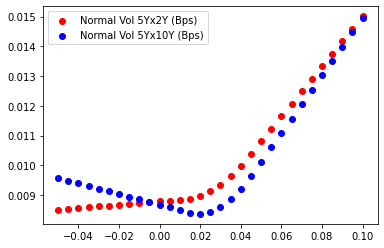

In [9]:
import matplotlib.pyplot as plt

strikes = np.linspace(-0.05, 0.1, 31)
vol_skew_2y = [vol_skew_5y2y(k) for k in strikes]
vol_skew_10y = [vol_skew_5y10y(k) for k in strikes]
plt.scatter(strikes, vol_skew_2y, color="red", label="Normal Vol 5Yx2Y (Bps)")
plt.scatter(strikes, vol_skew_10y, color="blue",  label="Normal Vol 5Yx10Y (Bps)")
plt.legend(loc="upper left")
plt.show()

#### PDF under the Level measure

Since the swaption market model used in this project is the normal (Bachelier), we expect the stripped PDF under the level measure to be similar to the normal distribution density function. Moreover, we also expect it to have more kurtosis and "fat" tails (especially on the right) thanks to the skew of normal volatilities used in our pricing.

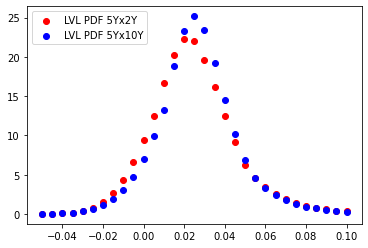

In [10]:
pdf_lvl_measure_2y = [copula_method.pdf_lvl_measure(k, tenor_2y, vol_skew_5y2y) for k in strikes]
pdf_lvl_measure_2y = [copula_method.pdf_lvl_measure(k, tenor_2y, vol_skew_5y2y) for k in strikes]
pdf_lvl_measure_10y = [copula_method.pdf_lvl_measure(k, tenor_10y, vol_skew_5y10y) for k in strikes]
plt.scatter(strikes, pdf_lvl_measure_2y, color="red", label="LVL PDF 5Yx2Y")
plt.scatter(strikes, pdf_lvl_measure_10y, color="blue",  label="LVL PDF 5Yx10Y")
plt.legend(loc="upper left")
plt.show()

#### CMS Spread Options Prices

In [11]:
strikes = np.linspace(0.002, 0.004, 3)
for strike in strikes :
    print("The price of 10Y-2Y Caplet CMS Spread Option with Expiry=5Y & Strike=" + str(strike) + " is : " + str(round(10000. * copula_method.price("Caplet", strike), 2)) + " Bps")

The price of 10Y-2Y Caplet CMS Spread Option with Expiry=5Y & Strike=0.002 is : 51.0 Bps
The price of 10Y-2Y Caplet CMS Spread Option with Expiry=5Y & Strike=0.003 is : 46.32 Bps
The price of 10Y-2Y Caplet CMS Spread Option with Expiry=5Y & Strike=0.004 is : 41.65 Bps


In [12]:
for strike in strikes :
    print("The price of 10Y-2Y Fllorlet CMS Spread Option with Expiry=5Y & Strike=" + str(strike) + " is : " + str(round(10000. * copula_method.price("Floorlet", strike), 2)) + " Bps")

The price of 10Y-2Y Fllorlet CMS Spread Option with Expiry=5Y & Strike=0.002 is : 36.92 Bps
The price of 10Y-2Y Fllorlet CMS Spread Option with Expiry=5Y & Strike=0.003 is : 41.07 Bps
The price of 10Y-2Y Fllorlet CMS Spread Option with Expiry=5Y & Strike=0.004 is : 45.21 Bps
